# SARIMA

In [13]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [5]:
# Dataset
def ModelSummary():
    friedman2 = requests.get('http://www.stata-press.com/data/r12/friedman2.dta').content
    data = pd.read_stata(BytesIO(friedman2))
    data.index = data.time

    # Variables
    endog = data.loc['1959':'1981', 'consump']
    exog = sm.add_constant(data.loc['1959':'1981', 'm2'])

    # Fit the model
    mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,0,1))
    res = mod.fit(disp=False)
    print(res.summary())


# Dataset
def FcstAndError():
    friedman2 = requests.get('http://www.stata-press.com/data/r12/friedman2.dta').content
    raw = pd.read_stata(BytesIO(friedman2))
    raw.index = raw.time
    data = raw.loc[:'1981']

    # Variables
    endog = data.loc['1959':, 'consump']
    exog = sm.add_constant(data.loc['1959':, 'm2'])
    nobs = endog.shape[0]

    # Fit the model
    mod = sm.tsa.statespace.SARIMAX(endog.loc[:'1978-01-01'], exog=exog.loc[:'1978-01-01'], order=(1,0,1))
    fit_res = mod.fit(disp=False)
    print(fit_res.summary())

    # 11
    mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,0,1))
    res = mod.filter(fit_res.params)

    # In-sample one-step-ahead predictions
    predict = res.get_prediction()
    predict_ci = predict.conf_int()

    # Dynamic predictions
    predict_dy = res.get_prediction(dynamic='1978-01-01')
    predict_dy_ci = predict_dy.conf_int()

    # Graph
    fig, ax = plt.subplots(figsize=(9,4))
    npre = 4
    ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

    # Plot data points
    data.loc['1977-07-01':, 'consump'].plot(ax=ax, style='o', label='Observed')

    # Plot predictions
    predict.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
    ci = predict_ci.loc['1977-07-01':]
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    predict_dy.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='g', label='Dynamic forecast (1978)')
    ci = predict_dy_ci.loc['1977-07-01':]
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

    legend = ax.legend(loc='lower right')

    plt.show()

    # Prediction error

    ## Graph
    fig, ax = plt.subplots(figsize=(9,4))
    npre = 4
    ax.set(title='Forecast error', xlabel='Date', ylabel='Forecast - Actual')

    ## In-sample one-step-ahead predictions and 95% confidence intervals
    predict_error = predict.predicted_mean - endog
    predict_error.loc['1977-10-01':].plot(ax=ax, label='One-step-ahead forecast')
    ci = predict_ci.loc['1977-10-01':].copy()
    ci.iloc[:,0] -= endog.loc['1977-10-01':]
    ci.iloc[:,1] -= endog.loc['1977-10-01':]
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.1)

    # Dynamic predictions and 95% confidence intervals
    predict_dy_error = predict_dy.predicted_mean - endog
    predict_dy_error.loc['1977-10-01':].plot(ax=ax, style='r', label='Dynamic forecast (1978)')
    ci = predict_dy_ci.loc['1977-10-01':].copy()
    ci.iloc[:,0] -= endog.loc['1977-10-01':]
    ci.iloc[:,1] -= endog.loc['1977-10-01':]
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

    legend = ax.legend(loc='lower left');
    legend.get_frame().set_facecolor('w')

    plt.show()

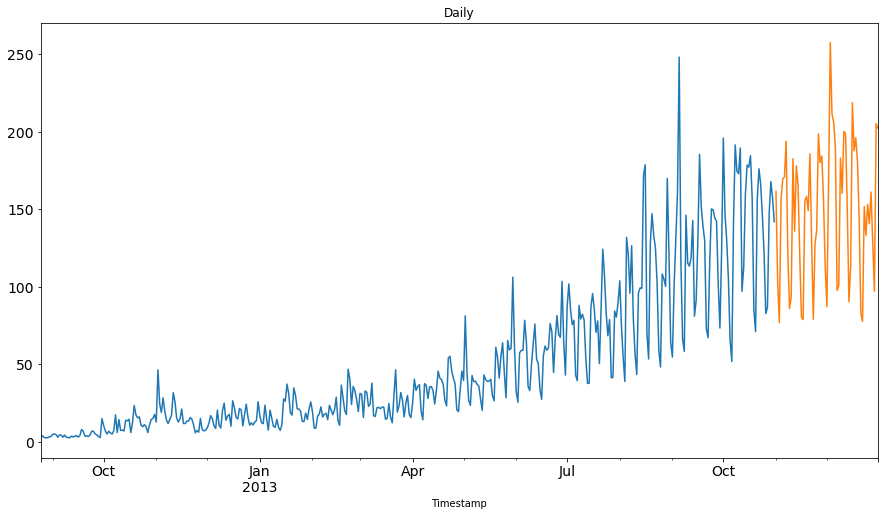

In [8]:
 # Data
df = pd.read_csv('D:/data/csv/TrainsTrain.csv', nrows = 11856) #subsetting
train = df[0:10392] 
test = df[10392:]
trn = np.asarray(train['Count'])
tst = np.asarray(test['Count'])
hor = len(tst)

# Daily aggregation
df['Timestamp'] = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 
df.index = df.Timestamp 
df = df.resample('D').mean()
train['Timestamp'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').mean() 
test['Timestamp'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean()

train.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14)
test.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14)
plt.show()

### ARIMA

In [27]:
def plot_fcst_valid(train, test, fcst):
    nH = len(train)
    nF = len(fcst)
    histIdx = np.arange(nH)
    fcstIdx = np.arange(nH, nH+nF)
    plt.figure(figsize=(20,10))
    plt.plot(histIdx, train, label='Train', Color='b', lw=1.)
    plt.plot(fcstIdx, test, label='Test', Color='g', lw=1.)
    plt.plot(fcstIdx, fcst, label='Fcst', Color='r', lw=1.)
    plt.legend(loc='best')
    plt.show()



In [47]:
idx = pd.date_range(pd.to_datetime("2000-01-01"), periods=len(trn)).tolist()
val = trn
df = pd.DataFrame(val)
df.index = idx
#mod = sm.tsa.statespace.SARIMAX(df, order=(1,0,1))
mod = sm.tsa.statespace.SARIMAX(df, order=(0, 1, 2), seasonal_order=(0, 1, 2, 12), enforce_invertibility=False, enforce_stationarity=False)
ft = mod.fit()

c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [48]:
s = pd.to_datetime("19-02-2000",dayfirst=True)
e = s + pd.DateOffset(days=hor-1)
fcstSeries = ft.predict(start=s, end=e, dynamic=True)
fcst = fcstSeries.values
fcst

array([ 6.91263653,  5.13488735,  4.46015139, ..., 12.27831691,
       12.9240016 , 15.69863804])

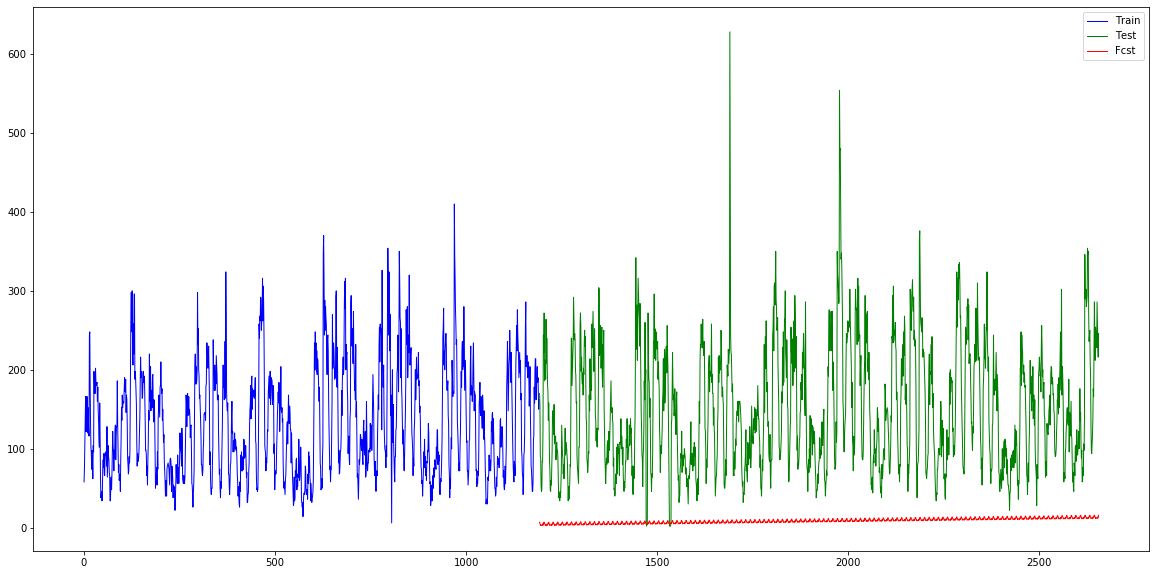

In [49]:
plot_fcst_valid(trn[9200:],tst,fcst)

In [ ]:
# 3. Arima
def test31_Model(self):
    ar.Model()
def test32_ModelAndCharts(self):
    ar.ModelAndCharts()
def test33_Model2(self):
    ar.Model2()

# 3. Sarima
def test41_ModelSummary(self):
    sa.ModelSummary()
def test42_FcstAndError(self):
   sa.FcstAndError()